In [1]:
import experiment_utils
from experiment_utils import config

config.experiment_name = "0002_poisson_dirichlet_fem"
config.target = "jmlr"
config.debug_mode = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import probnum as pn

import linpde_gp

plt.rcParams.update(config.tueplots_bundle())
plt.rcParams['text.usetex'] = True

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


## Problem Definition

In [3]:
domain = linpde_gp.domains.asdomain([-1.0, 1.0])

alpha = 1.0

rhs = linpde_gp.functions.Piecewise(
    xs=[-1.0, -0.3, 0.1, 1.0],
    fns=[
        linpde_gp.functions.Polynomial([3.0]),
        linpde_gp.functions.Polynomial([0.0]),
        linpde_gp.functions.Polynomial([2.0]),
    ],
)

In [4]:
solution = linpde_gp.problems.pde.Solution_PoissonEquation_IVP_1D_RHSPiecewisePolynomial(
    domain,
    rhs,
    initial_values=[-0.5, 3.0],
    alpha=alpha,
)

In [5]:
bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
    domain,
    rhs=rhs,
    boundary_values=np.asarray((solution(-1.), solution(1.))),
    solution=solution,
)

## Test and Trial Bases

In [6]:
num_finite_elements = 3

basis_grid = np.linspace(*bvp.domain, num_finite_elements + 2)

trial_basis = linpde_gp.functions.bases.UnivariateLinearInterpolationBasis(
    basis_grid,
    zero_boundary=False,
)

test_basis = linpde_gp.functions.bases.UnivariateLinearInterpolationBasis(
    basis_grid,
    zero_boundary=True,
)

trial_proj = trial_basis.l2_projection()
test_proj = test_basis.l2_projection(normalized=False)

In [7]:
diffop_galerkin = bvp.pde.diffop.weak_form(test_basis)(trial_basis)
rhs_galerkin = test_proj(bvp.pde.rhs)

In [8]:
diffop_galerkin.todense()

array([[-2.,  4., -2.,  0.,  0.],
       [ 0., -2.,  4., -2.,  0.],
       [ 0.,  0., -2.,  4., -2.]])

In [9]:
rhs_galerkin

array([1.23, 0.44, 0.98])

## Plotting

In [10]:
%matplotlib inline

import matplotlib.axes

from linpde_gp.typing import RandomProcessLike, RandomVariableLike

plt_grid = domain.uniform_grid(200)

def plot_belief(
    ax: matplotlib.axes.Axes,
    *,
    u: pn.randprocs.GaussianProcess,
    conditioned_on: list[str] = [],
    solution: RandomProcessLike | None = None,
    simplified: bool = False,
):
    # True Solution
    if solution is not None:
        solution.plot(
            ax,
            plt_grid,
            color="C1",
            label="$u^\star$",
        )

    # Solution Belief
    cond_events_str = _build_cond_events_str(conditioned_on)

    u.plot(
        ax,
        plt_grid,
        num_samples=3,
        rng=np.random.default_rng(24),
        color="C0",
        label=(
            fr"$\mathrm{{u}} \mid {cond_events_str}$"
            if len(cond_events_str) > 0
            else r"$\mathrm{u}$"
        ),
    )

    if simplified:
        ax.set(
            xlabel="Domain $\mathbb{D}$",
            xticks=[],
            yticks=[],
        )

    ax.legend()

def plot_proj_belief(
    ax: matplotlib.axes.Axes,
    *,
    u: pn.randprocs.GaussianProcess,
    conditioned_on: list[str] = [],
    solution: RandomProcessLike | None = None,
    samples: bool=True,
):
    # True Solution
    if solution is not None:
        linpde_gp.randprocs.asrandproc(solution).plot(
            ax,
            plt_grid,
            color="C1",
            label="$u^\star$",
        )

    # Projected Solution Belief
    Pu = trial_proj(u)

    Pu_gp = linpde_gp.randprocs.ParametricGaussianProcess(
        weights=Pu,
        feature_fn=trial_basis,
    )

    cond_events_str = _build_cond_events_str(conditioned_on)

    Pu_gp.plot(
        ax,
        plt_grid,
        num_samples=3 if samples else 0,
        rng=np.random.default_rng(24),
        color="C0",
        label=(
            fr"$\mathcal{{P}}[\mathrm{{u}}] \mid {cond_events_str}$"
            if len(cond_events_str) > 0
            else r"$\mathcal{P}[\mathrm{{u}}]$"
        ),
    )

    ax.legend()

def _build_cond_events_str(conditioned_on: list[str]) -> str:
    events = []

    for key in conditioned_on:
        match key:
            case "bc":
                events.append(r"\mathrm{BC}")
            case "bc_fem":
                events.append(r"\mathrm{BC}_\mathrm{FEM}")
            case "pde":
                events.append(r"\mathrm{PDE}")
            case "sc":
                events.append(r"\mathrm{SC}")
            case _:
                raise ValueError(f"Unknown event '{key}'")

    return ", ".join(events)

/app/experiments/experiment_utils/_tueplots_bundles.py:8: UserWarning: The `rel_height` argument is not supported for the JMLR bundle
  warnings.warn("The `rel_height` argument is not supported for the JMLR bundle")


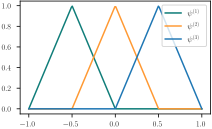

In [11]:
# Trial function plot for beamer
with plt.rc_context(config.tueplots_bundle(rel_width=0.5, rel_height=0.5)):
    evals = trial_basis(plt_grid)

    plt.plot(plt_grid, evals[:, 1:-1], label=[r"$\psi^{(1)}$", r"$\psi^{(2)}$", r"$\psi^{(3)}$"])

    plt.gca().legend()

experiment_utils.savefig("00_trial_functions_beamer")

## Prior

In [12]:
base_cov = pn.randprocs.covfuncs.Matern(
    input_shape=(),
    lengthscales=0.75,
    nu=1.5,
)

u_prior = pn.randprocs.GaussianProcess(
    mean=pn.functions.Zero(
        input_shape=(),
        output_shape=(),
    ),
    cov=linpde_gp.randprocs.covfuncs.GalerkinCovarianceFunction(
        base_cov,
        projection=trial_proj,
    ),
)

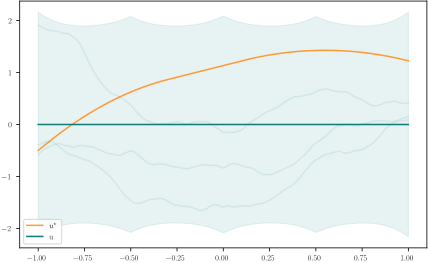

In [13]:
plot_belief(
    plt.gca(),
    u=u_prior,
    solution=bvp.solution,
)

# experiment_utils.savefig("00_u_prior")

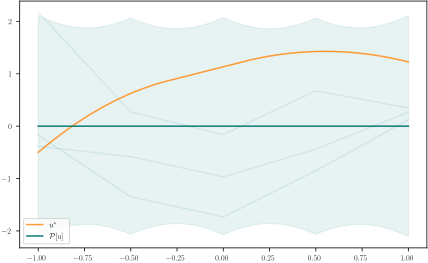

In [14]:
plot_proj_belief(
    plt.gca(),
    u=u_prior,
    solution=bvp.solution,
)

# experiment_utils.savefig("00_u_prior_proj")

/app/experiments/experiment_utils/_tueplots_bundles.py:8: UserWarning: The `rel_height` argument is not supported for the JMLR bundle
  warnings.warn("The `rel_height` argument is not supported for the JMLR bundle")


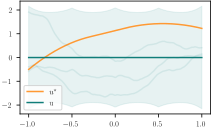

In [15]:
# MWR Prior Beamer Plot
with plt.rc_context(config.tueplots_bundle(rel_width=0.5, rel_height=0.5)):
    plot_belief(
        plt.gca(),
        u=u_prior,
        solution=bvp.solution,
    )

experiment_utils.savefig("01_u_mwr_prior")

## Posterior

### Conditioning on the Boundary Conditions

In [16]:
X_bc, Y_bc = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

In [17]:
u_cond_bc = u_prior.condition_on_observations(Y_bc, X=X_bc)

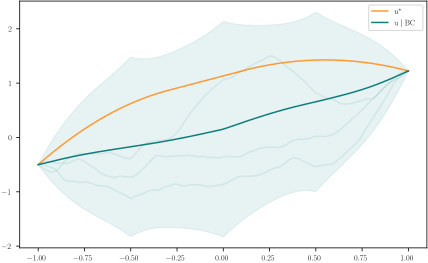

In [18]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
    solution=bvp.solution,
)

# experiment_utils.savefig("01_u_cond_bc")

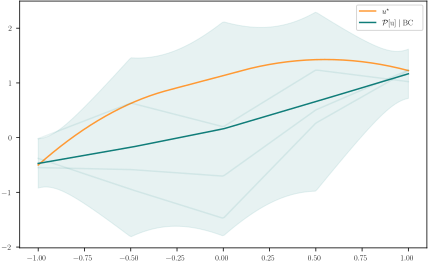

In [19]:
plot_proj_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
    solution=bvp.solution,
)

# experiment_utils.savefig("01_u_cond_bc_proj")

In [20]:
A_bc = np.eye(len(trial_basis))[[0, -1], :]

u_cond_bc = u_cond_bc.condition_on_observations(
    Y_bc,
    L=A_bc @ trial_proj,
)

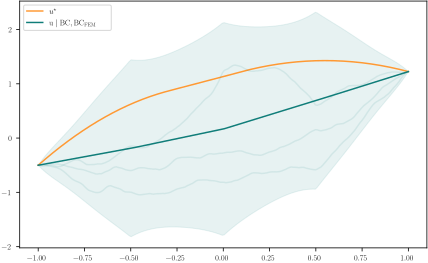

In [21]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc", "bc_fem"],
    solution=bvp.solution,
)

# experiment_utils.savefig("02_u_cond_bc_bc_fem")

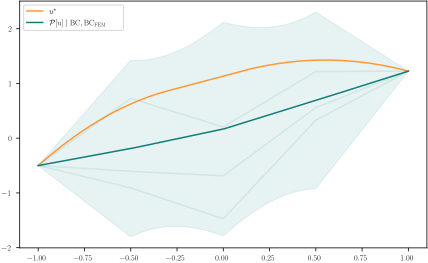

In [22]:
plot_proj_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc", "bc_fem"],
    solution=bvp.solution,
)

# experiment_utils.savefig("02_u_cond_bc_bc_fem_proj")

### Conditioning on the PDE

In [23]:
u_cond_bc_pde = u_cond_bc.condition_on_observations(
    rhs_galerkin,
    L=diffop_galerkin @ trial_proj,
)

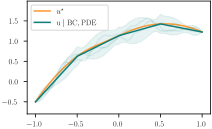

In [24]:
# MWR section plot
mwr_plots_ylim = (-0.8, 1.99)

with plt.rc_context(config.tueplots_bundle(rel_width=0.5)):
    plot_belief(
        plt.gca(),
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        solution=bvp.solution,
    )

    plt.ylim(*mwr_plots_ylim)

experiment_utils.savefig("03_u_cond_bc_bc_fem_pde")

/app/experiments/experiment_utils/_tueplots_bundles.py:8: UserWarning: The `rel_height` argument is not supported for the JMLR bundle
  warnings.warn("The `rel_height` argument is not supported for the JMLR bundle")


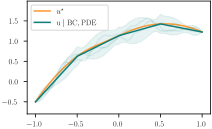

In [25]:
# MWR Beamer Plot
mwr_plots_ylim = (-0.8, 1.99)

with plt.rc_context(config.tueplots_bundle(rel_width=0.5, rel_height=0.5)):
    plot_belief(
        plt.gca(),
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        solution=bvp.solution,
    )

    plt.ylim(*mwr_plots_ylim)

experiment_utils.savefig("03_u_cond_bc_bc_fem_pde_beamer")

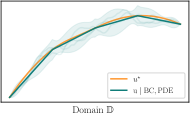

In [26]:
# Figure 1 Plot
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=0.45,
        # height_to_width_ratio=fig_1_plot_aspect,
    )
):
    plot_belief(
        plt.gca(),
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        solution=bvp.solution,
        simplified=True,
    )

    experiment_utils.savefig("03_u_cond_bc_bc_fem_pde_fig_1")

/app/probnum/src/probnum/randprocs/_random_process.py:270: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(args=args))


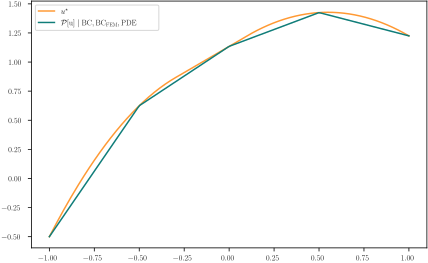

In [27]:
plot_proj_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "bc_fem", "pde"],
    solution=bvp.solution,
    samples=False,  # The covariance matrix is numerically indefinite
)

# experiment_utils.savefig("03_u_cond_bc_bc_fem_pde_proj")

### Testing

In [28]:
import scipy.integrate

phis_grid = trial_basis(plt_grid)

def sample_trial_proj(sample):
    res = scipy.integrate.trapezoid(
        phis_grid * sample[..., None],
        plt_grid,
        axis=0,
    )

    return trial_proj.normalizer(res)

samples = np.stack(
    [
        sample - np.sum(sample_trial_proj(sample) * phis_grid, axis=-1)
        for sample in u_cond_bc.sample(np.random.default_rng(24), plt_grid, size=(2000,))
    ],
    axis=-1,
)

samples_std = np.std(samples, axis=-1)

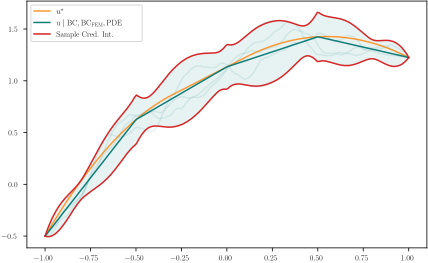

In [29]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "bc_fem", "pde"],
    solution=bvp.solution,
)

post_mean = u_cond_bc_pde.mean(plt_grid)

plt.plot(plt_grid, post_mean + 1.96 * samples_std, c="C3", label="Sample Cred. Int.")
plt.plot(plt_grid, post_mean - 1.96 * samples_std, c="C3")

plt.legend()

# experiment_utils.savefig("posterior_std_samples")

## Comparison to regular GP Prior

In [30]:
u_full_prior = pn.randprocs.GaussianProcess(
    mean=pn.functions.Zero(
        input_shape=(),
        output_shape=(),
    ),
    cov=base_cov,
)

In [31]:
u_full_cond_bc = u_full_prior.condition_on_observations(Y_bc, X=X_bc)

In [32]:
u_full_cond_bc_pde = u_full_cond_bc.condition_on_observations(
    rhs_galerkin,
    L=diffop_galerkin @ trial_proj,
)

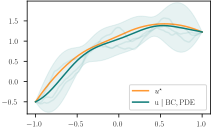

In [33]:
# MWR section plot
with plt.rc_context(config.tueplots_bundle(rel_width=0.5)):
    plot_belief(
        plt.gca(),
        u=u_full_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        solution=bvp.solution,
    )

    plt.ylim(*mwr_plots_ylim)

experiment_utils.savefig("05_u_full_cond_bc_pde")

/app/experiments/experiment_utils/_tueplots_bundles.py:8: UserWarning: The `rel_height` argument is not supported for the JMLR bundle
  warnings.warn("The `rel_height` argument is not supported for the JMLR bundle")


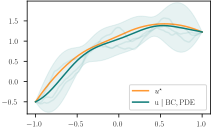

In [34]:
# MWR beamer plot
with plt.rc_context(config.tueplots_bundle(rel_width=0.5, rel_height=0.5)):
    plot_belief(
        plt.gca(),
        u=u_full_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        solution=bvp.solution,
    )

    plt.ylim(*mwr_plots_ylim)

experiment_utils.savefig("05_u_full_cond_bc_pde_beamer")